# Definitions

* $ L $: Levels of simulation. $ x \in L$ and $ x \notin Y \subsetneq L$
* $ p_x $: A person on level-x.
* $ t_{x \rightarrow Y} $: # of tell from level-x person to each level-Y person.
* $ u_x $: Understanding of level-x person. $ 0 \leq u_x \leq 1 $.

```mermaid
graph TD
    1[p_1, has u_1]
    subgraph team1[ ]
      11[p_2, has u_2] -- t_2->{3} -->
        l11[p_3, has u_3] & l12[p_3, has u_3]
      12[p_2, has u_2] -- t_2->{3} -->
      121[p_3, has u_3] & 122[p_3, has u_3]
    end
    1 -- t_1->{2} --> 11 & 12
    1 -- t_1->{2,3} --> team1

```

# Simulations

## Top-down message to members

It means,

* $ L = \{1\}$
* $ | p_1 | = 1 $
* $ t_{x \rightarrow Y} $ cannot be defined.
* $ u_1 = 1$

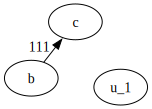

In [26]:
import pygraphviz as pgv

G = pgv.AGraph(directed=True)
G.add_node("()", label="u_1")
G.add_edge("b", "c", label="111")
G.layout()
G